## import libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import re
import nltk
import warnings
warnings.filterwarnings('ignore')
from textblob import TextBlob
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import plotly.express as px
import string
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from PIL import Image

In [2]:
data = pd.read_csv('netflixData.csv')

## EDA - Exploratory Data Analyis

In [3]:
data.head()

,Show Id,Title,Description,Director,Genres,Cast,Production Country,Release Date,Rating,Duration,Imdb Score,Content Type,Date Added
0,cc1b6ed9-cf9e-4057-8303-34577fb54477,(Un)Well,This docuseries takes a deep dive into the luc...,NaN,Reality TV,NaN,United States,2020.0,TV-MA,1 Season,6.6/10,TV Show,NaN
1,e2ef4e91-fb25-42ab-b485-be8e3b23dedb,#Alive,"As a grisly virus rampages a city, a lone man ...",Cho Il,"Horror Movies, International Movies, Thrillers","Yoo Ah-in, Park Shin-hye",South Korea,2020.0,TV-MA,99 min,6.2/10,Movie,"September 8, 2020"
2,b01b73b7-81f6-47a7-86d8-acb63080d525,#AnneFrank - Parallel Stories,"Through her diary, Anne Frank's story is retol...","Sabina Fedeli, Anna Migotto","Documentaries, International Movies","Helen Mirren, Gengher Gatti",Italy,2019.0,TV-14,95 min,6.4/10,Movie,"July 1, 2020"
3,b6611af0-f53c-4a08-9ffa-9716dc57eb9c,#blackAF,Kenya Barris and his family navigate relations...,NaN,TV Comedies,"Kenya Barris, Rashida Jones, Iman Benson, Genn...",United States,2020.0,TV-MA,1 Season,6.6/10,TV Show,NaN
4,7f2d4170-bab8-4d75-adc2-197f7124c070,#cats_the_mewvie,This pawesome documentary explores how our fel...,Michael Margolis,"Documentaries, International Movies",NaN,Canada,2020.0,TV-14,90 min,5.1/10,Movie,"February 5, 2020"


In [4]:
data.sample()

,Show Id,Title,Description,Director,Genres,Cast,Production Country,Release Date,Rating,Duration,Imdb Score,Content Type,Date Added
4619,30b0bacc-d3a4-4482-a86e-0dafb34de074,The American Game,A financially struggling young couple's relati...,Mostafa Abu Seif,"Comedies, International Movies, Romantic Movies","Nahed El Sebaï, Ahmed Fahmi, Shaima Saif, Bayo...",NaN,2019.0,TV-PG,91 min,NaN,Movie,"October 1, 2020"


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5967 entries, 0 to 5966
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Show Id             5967 non-null   object 
 1   Title               5967 non-null   object 
 2   Description         5967 non-null   object 
 3   Director            3903 non-null   object 
 4   Genres              5967 non-null   object 
 5   Cast                5437 non-null   object 
 6   Production Country  5408 non-null   object 
 7   Release Date        5964 non-null   float64
 8   Rating              5963 non-null   object 
 9   Duration            5964 non-null   object 
 10  Imdb Score          5359 non-null   object 
 11  Content Type        5967 non-null   object 
 12  Date Added          4632 non-null   object 
dtypes: float64(1), object(12)
memory usage: 606.1+ KB


In [7]:
data.isnull().sum()

Show Id                  0
Title                    0
Description              0
Director              2064
Genres                   0
Cast                   530
Production Country     559
Release Date             3
Rating                   4
Duration                 3
Imdb Score             608
Content Type             0
Date Added            1335
dtype: int64

### Sadece kullanacağımız sutunları alalım

In [8]:
data = data[['Title', 'Description', 'Content Type', 'Genres']]
data.sample(5)

,Title,Description,Content Type,Genres
2250,Inmates,"While living under one roof, five close-knit 2...",TV Show,"International TV Shows, TV Comedies"
5210,The Soul,While investigating the death of a businessman...,Movie,"Dramas, International Movies, Thrillers"
190,Abzurdah,A disenfranchised 16-year-old girl connects to...,Movie,"Dramas, International Movies"
4016,Rowdy Rathore,A con man uncovers a deadly secret and must sa...,Movie,"Action & Adventure, Comedies, International Mo..."
1320,Dirty Money,From crippling payday loans to cars that cheat...,TV Show,"Crime TV Shows, Docuseries"


In [9]:
data.isnull().sum()

Title           0
Description     0
Content Type    0
Genres          0
dtype: int64

### Title nltk temizlik

In [10]:
data.Title[3]

'#blackAF'

In [17]:
def clean_text(text): 
    text = str(text).lower()    ## metindeki harfleri kucuk harfe çevirir.
    text = re.sub('\[.*?\]', '', text)   ## metindeki url ya da emoji gibi şeyleri kaldırır.
    text = re.sub('<.*?>+', '', text)    ## Metindeki HTML etiketlerini kaldırır.
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  ## Metindeki noktalama işaretlerini kaldırır.
    text = re.sub('\n', '', text)    ## Metindeki satır sonlarını kaldırır.
    text = re.sub('\w*\d\w*', '', text)   ## Metindeki içinde sayı olan kelimeleri kaldırır.
    
    pr = PorterStemmer()
    words = TextBlob(text).words
    text = [pr.stem(word) for word in words]
    text = ' '.join(text)
    return text

In [18]:
data['Title'] = data['Title'].apply(clean_text)

In [19]:
data.Title[3]

'blackaf'

## Cosinus Uzaklığına göre Recommender Sistem

In [21]:
genres = data['Genres'].tolist()

In [26]:
vect = TfidfVectorizer(stop_words = 'english')

In [27]:
vect_matrix = vect.fit_transform(genres)

In [28]:
similarity = cosine_similarity(vect_matrix)

In [29]:
similarity

array([[1.        , 0.        , 0.        , ..., 0.32075218, 0.        ,
        0.        ],
       [0.        , 1.        , 0.30428612, ..., 0.07587812, 0.68953015,
        0.15936057],
       [0.        , 0.30428612, 1.        , ..., 0.11962968, 0.27899812,
        0.12562419],
       ...,
       [0.32075218, 0.07587812, 0.11962968, ..., 1.        , 0.25478887,
        0.        ],
       [0.        , 0.68953015, 0.27899812, ..., 0.25478887, 1.        ,
        0.110801  ],
       [0.        , 0.15936057, 0.12562419, ..., 0.        , 0.110801  ,
        1.        ]])

In [30]:
indices = pd.Series(data.index, index = data['Title']).drop_duplicates()

In [31]:
def netflix_recommendation(title, similarity_matrix=similarity, indices=indices):
    index = indices[title]
    scores = list(enumerate(similarity_matrix[index]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    scores = scores[:10]
    movie_indices = [i[0] for i in scores]
    recommended_movies = data['Title'].iloc[movie_indices]
    return recommended_movies


In [37]:
netflix_recommendation('balloon')

64                  balloon
107           a ghost stori
140            a privat war
288     all day and a night
335          american woman
570      beast of no nation
825          brother shadow
847               burn sand
994                christin
1080         concret cowboy
Name: Title, dtype: object

## WordCloud

In [41]:
def wordcloud(data, bgcolor):
    plt.figure(figsize = (10, 10))
    mask = np.array(Image.open("netflix.png"))
    wc = WordCloud(background_color = bgcolor, stopwords = STOPWORDS, mask = mask)   
    wc.generate(' '.join(data)) # butun mesajları birleştirip tek bir text haline getirir.
    plt.imshow(wc)
    plt.axis("off")

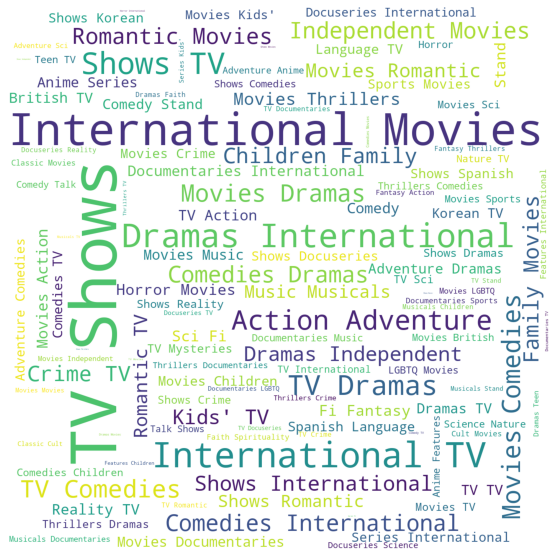

In [44]:
wordcloud(data['Genres'], 'white')